Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Text(value='')

Button(description='Predict', style=ButtonStyle())

Reading image /content/drive/My Drive/iwm2/pics/01_h.jpg
Reading image /content/drive/My Drive/iwm2/pics/01_h.jpg


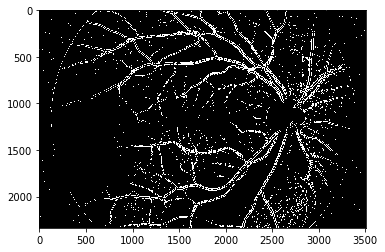

3577
Printing final picture


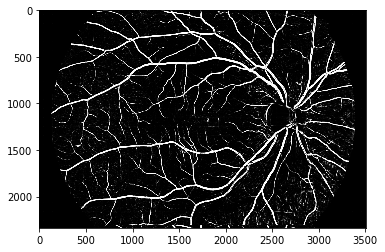

Reading image /content/drive/My Drive/iwm2/pics/01_h.tif
Accuracy 0.8990140182257459
Sensitivity 0.3667219098967727
Specificity 0.9593928059965264
Accuracy 0.8986228312456996
Sensitivity 0.00489394259181089
Specificity 1.0
0.6630573579466497
0.2500863911074513
0.5024469712959054
0.10627111134611127


In [13]:
import cv2
from keras_preprocessing.image import img_to_array, array_to_img
from matplotlib import pyplot as plt
from skimage import filters
import numpy as np
from keras import *
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, core
from keras.engine.saving import model_from_json
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from IPython.display import display
from ipywidgets import widgets
drive.mount('/content/drive/')


def get_picture(i, mask=False):
    if i < 10:
        i = '0{}'.format(i)
    if mask == True:
      filename = '/content/drive/My Drive/iwm2/pics/{}_h.tif'.format(i)
    else:
      filename = '/content/drive/My Drive/iwm2/pics/{}_h.jpg'.format(i)
    bwimage = preprocess_image(filename)
    return bwimage

def read_image(path):
    print('Reading image ' + path)
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    return im, imgray


def equalize_histogram(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    return img


def normalize(img):
    new_img = np.empty((img.shape[0], img.shape[1]), dtype=float)
    for im in range(0, img.shape[0]):
        for i in range(0, img.shape[1]):
            new_img[im][i] = float(img[im][i]/255.0)
    return new_img


def preprocess_image(filename):
    im, imgray = read_image(filename)
    imgray = equalize_histogram(imgray)
    imgray = normalize(imgray)
    return imgray


def basic_method(i):
    if i < 10:
        i = '0{}'.format(i)
    filename = '/content/drive/My Drive/iwm2/pics/{}_h.jpg'.format(i)
    im, imgray = read_image(filename)
    cv2.equalizeHist(imgray, imgray)

    cv2.GaussianBlur(imgray, (3, 3), 3, imgray)
    cv2.medianBlur(imgray, 5, imgray)
    bwimage = imgray
    bwimage = filters.sobel(imgray)
    #     print(im)
    for pixel in range(0, bwimage.shape[0]):
        for i in range(0, bwimage.shape[1]):
            if im[pixel][i].all() == 0:
                bwimage[pixel][i] = 0
                continue
            if bwimage[pixel][i] < 0.025:
                bwimage[pixel][i] = 0
            else:
                bwimage[pixel][i] = 1
    plt.imshow(bwimage, cmap=plt.get_cmap("gray"))
    plt.show()
    return bwimage


def extract_patches(img):
    p = []
    i = 0
    for x in range(0, img.shape[0], 48):
        for y in range(0, img.shape[1], 48):
            patch = img[x:x + 48, y:y + 48]
            if patch.shape != (48, 48):
                new_patch = np.empty((48, 48))
                for x in range(0, patch.shape[0]):
                    for y in range(0, patch.shape[1]):
                        new_patch[x][y] = patch[x][y]
                patch = new_patch
            i += 1
            p.append(img_to_array(patch, data_format="channels_first"))
    print(i)
    return np.array(p)


def get_images(img):
    images = []
    patches = extract_patches(img)
    images.extend(patches)
    return np.array(images)

def get_final_patches(pred):
    patches = np.empty((pred.shape[0], pred.shape[1]))
    for i in range(pred.shape[0]):
        for pix in range(pred.shape[1]):
            patches[i, pix] = pred[i, pix, 1]
    patches = np.reshape(patches, (patches.shape[0], 1, 48, 48))
    return patches

def get_partial_image(img, finalpic):
    patches_imgs_test = get_images(img)
    predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)

    patches = get_final_patches(predictions)
    x = 0
    y = 0
    for pic in patches:
        for p in pic:
            temp = finalpic[x:x + 48, y:y + 48]
            finalpic[x:x + 48, y:y + 48] = p[0:0 + temp.shape[0], 0:0 + temp.shape[1]]
            y += 48
            if y + 48 > img.shape[1]:
                y = 0
                x += 48
    return finalpic


def calculate_metrics(img1, img2):
    tn, fp, fn, tp = confusion_matrix(img1, img2).ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    print("Accuracy {}".format(acc))
    sen = tp / (tp + fn)
    print("Sensitivity {}".format(sen))
    spec = tn / (tn + fp)
    print("Specificity {}".format(spec))

    
def predict_img(imgNo):
  img = get_picture(imgNo)
  basic_img = basic_method(imgNo)
  json_file = open('/content/drive/My Drive/iwm2/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights("/content/drive/My Drive/iwm2/weights.h5")

  finalpic = np.empty((img.shape[0], img.shape[1]))

  finalpic = get_partial_image(img, finalpic)

  print("Printing final picture")
  plt.imshow(finalpic, cmap=plt.get_cmap("gray"))
  plt.show()

  ground_truth = get_picture(imgNo, mask=True)
  calculate_metrics(ground_truth.astype(int).flatten(), basic_img.astype(int).flatten())
  print("Average precision score")
  print(average_precision_score(ground_truth.astype(int).flatten(), basic_img.astype(int).flatten()))
  calculate_metrics(ground_truth.astype(int).flatten(), finalpic.astype(int).flatten())
  print("Average precision score")
  print(average_precision_score(ground_truth.astype(int).flatten(), finalpic.astype(int).flatten()))

  finalpic *= 255
  cv2.imwrite("/content/drive/My Drive/iwm2/results/{}_nn.jpg".format(imgNo), finalpic)

  basic_img *= 255
  cv2.imwrite("/content/drive/My Drive/iwm2/results/{}_basic.jpg".format(imgNo), basic_img)

def on_button_clicked(b):
  if text.value != "":
    predict_img(int(text.value))
  else:
    print("Enter image number")
  
text = widgets.Text()
display(text)

button = widgets.Button(description="Predict")
display(button)
button.on_click(on_button_clicked)
